# Set-Up

In [1]:
import jax
import jax.numpy as jnp
import approx_post
import oed_toolbox
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.insert(0, '..')
import plotting_helpers
import computation_helpers
from arraytainers import Jaxtainer

In [2]:
# Plot theme:
sns.set_theme(style='darkgrid')
sns.set({'figure.facecolor':'white'})

In [3]:
fig_save_dir = './figs'
if not os.path.isdir(fig_save_dir):
    os.makedirs(fig_save_dir)

# Plotting Functions

In [4]:
palette = sns.color_palette()
samples_per_d = 100

In [5]:
def plot_data(y, d, model, theta_lims=(-5,5)):
    y_reshaped = y.reshape(-1, samples_per_d)
    d_reshaped = d.reshape(-1, samples_per_d)
    theta = jnp.linspace(theta_lims[0], theta_lims[1], samples_per_d)
    fig, ax = plt.subplots()
    for idx, (y_i, d_i) in enumerate(zip(y_reshaped, d_reshaped)):
        d_val = d_i[0]
        sns.scatterplot(x=theta.squeeze(), y=y_i.squeeze())
        sns.lineplot(x=theta.squeeze(), y=model(theta,d_val).squeeze(), label=f"d={d_val:.1f}", color=palette[idx])
        plt.xlabel("Parameter $\\theta$")
        plt.ylabel("Observations $y$")
    
    return fig

In [27]:
def plot_phi_function(amortised_dist, d_idx=None, d=None, y_obs=None, model=None, y_lims=(-50,50), num_y_pts=200, theta_lims=(-5,5)):
    y = jnp.linspace(y_lims[0], y_lims[1], num_y_pts).reshape(-1,1)
    if (d is None) and (d_idx is None):
        d_plot = 0.0
        pred_phi = amortised_dist.phi(y)
    else:
        d_plot = d.reshape(-1,samples_per_d)[d_idx,:][0]
        pred_phi = amortised_dist.phi(y, d_plot)
    pred_mean, pred_std = pred_phi['mean'].squeeze(), jnp.exp(pred_phi['log_chol_diag']).squeeze()
    mean_plus_cov = pred_mean + 2*pred_std
    mean_minus_cov = pred_mean - 2*pred_std
    
    x_plt = y.squeeze()
    ax = sns.lineplot(x=x_plt, y=pred_mean, label=f"Predicted Mean", color='red')
    sns.lineplot(x=x_plt, y=mean_plus_cov, color='red', linestyle='--')
    sns.lineplot(x=x_plt, y=mean_minus_cov, color='red', linestyle='--')
    ax.fill_between(x_plt, mean_minus_cov, mean_plus_cov, color="red", alpha=0.2)
    if y_obs is not None:
        y_plot = y_obs.reshape(-1,samples_per_d)[d_idx,:]
        true_theta = jnp.linspace(theta_lims[0], theta_lims[1], samples_per_d)
        sns.scatterplot(x=y_plot.squeeze(), y=true_theta.squeeze(), label=f"Observations") 
    if model is not None:
        true_theta = jnp.linspace(theta_lims[0], theta_lims[1], samples_per_d)
        theta1 = true_theta[:int(true_theta.size/2)]
        sns.lineplot(x=model(theta1.squeeze(), d_plot), y=theta1.squeeze(), label=f"Model $f(\\theta, d)$", color='g', linewidth=3)
        theta2 = true_theta[int(true_theta.size/2):]
        sns.lineplot(x=model(theta2.squeeze(), d_plot), y=theta2.squeeze(), color='g', linewidth=3)
    plt.xlabel("Observation $y$")
    plt.ylabel("Parameter $\\theta$")

# Artificial Data Creation

In [7]:
def create_data(model, d_vals, noise_cov, prngkey, theta_lims=(-5,5)):
    theta = jnp.linspace(theta_lims[0], theta_lims[1], samples_per_d)
    # Zero-mean samples:
    epsilon = jax.random.multivariate_normal(prngkey, mean=jnp.zeros((1,)), 
                                             cov=noise_cov, shape=(samples_per_d,)) # shape = (num_batch, dim_x)
    y, d = [], []
    for d_i in d_vals:
        mean_vals = model(theta, d_i).reshape(samples_per_d, -1) # shape = (num_batch, dim_theta)
        y.append(mean_vals + epsilon) # shape = (num_batch, x_dim)
        d.append(jnp.repeat(d_i, repeats=samples_per_d).reshape(samples_per_d, -1))
    return jnp.concatenate(y, axis=0), jnp.concatenate(d, axis=0)

In [8]:
# Define model:
ndim = 1
# model_func = lambda theta, d: d*theta**2
def model_func(theta, d):
    y = d*theta**2
    return y

/tmp/ipykernel_245284/1848128475.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


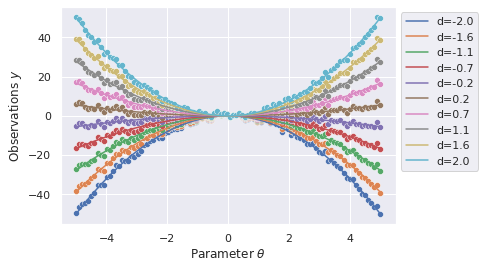

In [9]:
prngkey = jax.random.PRNGKey(42)
d_vals = jnp.linspace(-2, 2, 10) #, 1.5
noise_cov = jnp.identity(ndim)
y, d = create_data(model_func, d_vals, noise_cov, prngkey)
fig = plot_data(y, d, model_func)
fig.show()
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(fig_save_dir, 'amortised_data.pdf'), bbox_inches='tight')

In [10]:
prior_mean = jnp.zeros(ndim)
prior_cov = jnp.identity(ndim)
noise_cov = jnp.identity(ndim)

Now let's try include $d$:

In [11]:
model, model_grad = approx_post.models.from_jax(model_func)
joint_dist = approx_post.distributions.joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)
prngkey = jax.random.PRNGKey(10)
approx_dist = approx_post.distributions.approx.Gaussian(1)
preprocessing = approx_post.distributions.amortised.Preprocessing.std_scaling(y, d) #,d
phi_lims = None 
reverse_approx = approx_post.distributions.amortised.NeuralNetwork(approx_dist, x_dim=1, d_dim=1, prngkey=prngkey, 
                                                                   num_layers=5, width=5, activation='tanh',
                                                                   preprocessing=preprocessing, phi_lims=phi_lims)

In [12]:
loss = approx_post.losses.ELBO(joint_dist, use_reparameterisation=True)
optimiser = approx_post.optimisers.Adam()
loss = optimiser.fit(reverse_approx, loss, x=y, d=d, prngkey=prngkey, verbose=True, num_samples=1000, max_iter=100) 

Loss = 93.38684844970703, Params = Jaxtainer({'W_0': DeviceArray([[ 0.60573757, -0.18924844,  1.135692  , -0.42174807,
              -1.4182752 ],
             [ 0.54226005, -0.23708427, -0.27424976,  0.83836293,
              -0.35252082]], dtype=float32), 'b_0': DeviceArray([ 0.09999999,  0.09999999, -0.09999999, -0.1       ,
              0.09999999], dtype=float32), 'W_1': DeviceArray([[-0.16566357, -0.56231135, -0.47581702, -0.31056714,
               0.5343586 ],
             [-0.29493076,  1.270614  , -1.3519593 ,  0.40102258,
              -0.00757471],
             [-0.5706646 ,  0.73799896,  0.21807295,  0.47774735,
              -0.23291188],
             [-0.12278592,  0.9858867 ,  0.6705841 , -0.5291183 ,
              -0.8476602 ],
             [-1.1499256 ,  0.89719653,  0.9151989 ,  0.47091696,
               1.0498979 ]], dtype=float32), 'b_1': DeviceArray([ 0.1       , -0.09999999,  0.1       ,  0.1       ,
             -0.1       ], dtype=float32), 'W_2': DeviceArray

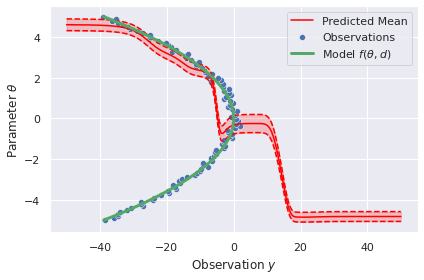

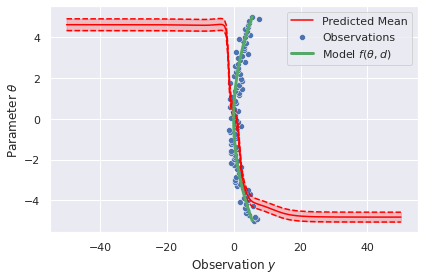

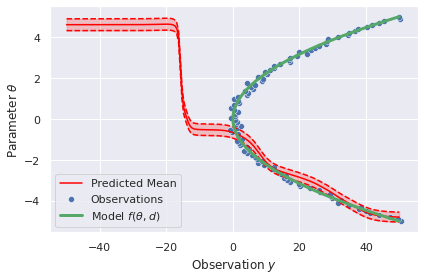

In [28]:
d_idx_to_plot= [1, 5, 10]
for d_idx in d_idx_to_plot:
    fig, ax = plt.subplots()
    plot_phi_function(reverse_approx, d_idx, d=d, y_obs=y, model=model_func)
    plt.tight_layout()
    plt.savefig(os.path.join(fig_save_dir, f'reverse_amortised_d_idx={d_idx}.pdf'), bbox_inches='tight')

Try Forward KL divergence:

In [14]:
model, model_grad = approx_post.models.from_jax(model_func)
joint_dist = approx_post.distributions.joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)
prngkey = jax.random.PRNGKey(10)
approx_dist = approx_post.distributions.approx.Gaussian(1)
preprocessing = approx_post.distributions.amortised.Preprocessing.std_scaling(y, d) #,d
phi_lims = None 
forward_approx = approx_post.distributions.amortised.NeuralNetwork(approx_dist, x_dim=1, d_dim=1, prngkey=prngkey, 
                                                                   num_layers=5, width=5, activation='tanh', 
                                                                   preprocessing=preprocessing, phi_lims=phi_lims)

In [15]:
loss = approx_post.losses.ForwardKL(joint_dist, use_reparameterisation=False)
optimiser = approx_post.optimisers.Adam()
loss = optimiser.fit(forward_approx, loss, x=y, d=d, prngkey=prngkey, verbose=True, num_samples=1000, max_iter=100) 

Loss = 0.0043114181607961655, Params = Jaxtainer({'W_0': DeviceArray([[ 0.60567313, -0.38894716,  1.1360339 , -0.42176178,
              -1.6181524 ],
             [ 0.5421534 , -0.23705661, -0.27421334,  0.83869797,
              -0.352473  ]], dtype=float32), 'b_0': DeviceArray([-0.09988259,  0.09994625,  0.099891  ,  0.09997091,
              0.09920505], dtype=float32), 'W_1': DeviceArray([[-0.16560441, -0.562197  , -0.47582442, -0.31056982,
               0.5343513 ],
             [-0.29497096,  1.2703509 , -1.3519523 ,  0.40102518,
              -0.00756768],
             [-0.5706038 ,  0.9379423 ,  0.21806532,  0.47774443,
              -0.23291966],
             [-0.1228167 ,  0.9859233 ,  0.6705909 , -0.52911556,
              -0.8476529 ],
             [-1.1500049 ,  0.6973335 ,  0.9152067 ,  0.47091988,
               1.0499057 ]], dtype=float32), 'b_1': DeviceArray([ 0.09999681,  0.09996517,  0.09999564,  0.09999851,
             -0.0999978 ], dtype=float32), 'W_2': DeviceA

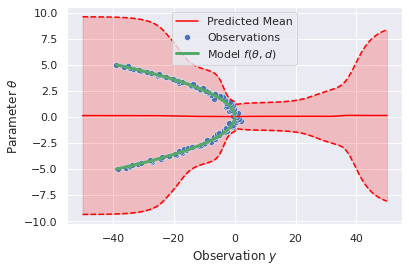

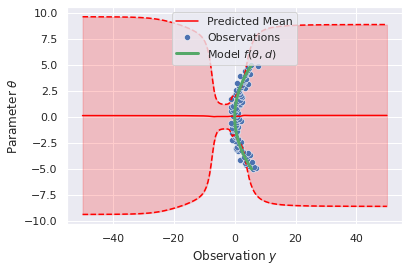

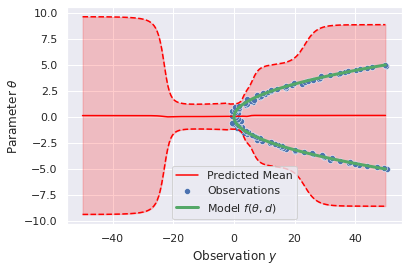

In [29]:
d_idx_to_plot= [1, 5, 10]
for d_idx in d_idx_to_plot:
    fig, ax = plt.subplots()
    plot_phi_function(forward_approx, d_idx, d=d, y_obs=y, model=model_func)
    plt.savefig(os.path.join(fig_save_dir, f'forward_amortised_d_idx={d_idx}.pdf'), bbox_inches='tight')